# **数据预处理部分**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score

device = torch.device("cuda:0")

# 数据预处理
# 训练集
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 随机裁剪
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(), #归一化
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR10 均值 标准差
])

# 测试集
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载数据集
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# CIFAR-10类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# **构建RESNET网络**

In [2]:
# 残差块
class BasicBlock(nn.Module):
    expansion = 1  # 扩展系数，用于调整通道数变化
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # 第一个卷积层 3*3卷积核
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 第二个卷积层 3*3卷积核
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 残差连接（当维度不匹配时用1x1卷积调整）
        self.shortcut = nn.Sequential()

        # 当维度不匹配时用1x1卷积核调整至相应维度
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

        # 残差块前向传播
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

# ResNet整体搭建
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # 初始卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 残差层
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # 全连接层
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        # 堆叠残差层
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)  # 第一个块可能有下采样
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    # 前向传播
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))  # 初始卷积
        out = self.layer1(out)  #残差层
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)  # 全局平均池化
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# 创建ResNet18
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# 初始化模型
model = ResNet18().to(device)

# **训练设置**

Epoch [1/100], Loss: 1.9868
Epoch [2/100], Loss: 1.5227
Epoch [3/100], Loss: 1.2976
Epoch [4/100], Loss: 1.0830
Epoch [5/100], Loss: 0.9268
Epoch [6/100], Loss: 0.8378
Epoch [7/100], Loss: 0.7332
Epoch [8/100], Loss: 0.6572
Epoch [9/100], Loss: 0.5943
Epoch [10/100], Loss: 0.5560
Epoch [11/100], Loss: 0.5296
Epoch [12/100], Loss: 0.5056
Epoch [13/100], Loss: 0.4857
Epoch [14/100], Loss: 0.4761
Epoch [15/100], Loss: 0.4557
Epoch [16/100], Loss: 0.4465
Epoch [17/100], Loss: 0.4398
Epoch [18/100], Loss: 0.4315
Epoch [19/100], Loss: 0.4200
Epoch [20/100], Loss: 0.4175
Epoch [21/100], Loss: 0.4099
Epoch [22/100], Loss: 0.3968
Epoch [23/100], Loss: 0.3907
Epoch [24/100], Loss: 0.3933
Epoch [25/100], Loss: 0.3895
Epoch [26/100], Loss: 0.3851
Epoch [27/100], Loss: 0.3797
Epoch [28/100], Loss: 0.3706
Epoch [29/100], Loss: 0.3740
Epoch [30/100], Loss: 0.3673
Epoch [31/100], Loss: 0.3709
Epoch [32/100], Loss: 0.3655
Epoch [33/100], Loss: 0.3626
Epoch [34/100], Loss: 0.3552
Epoch [35/100], Loss: 0

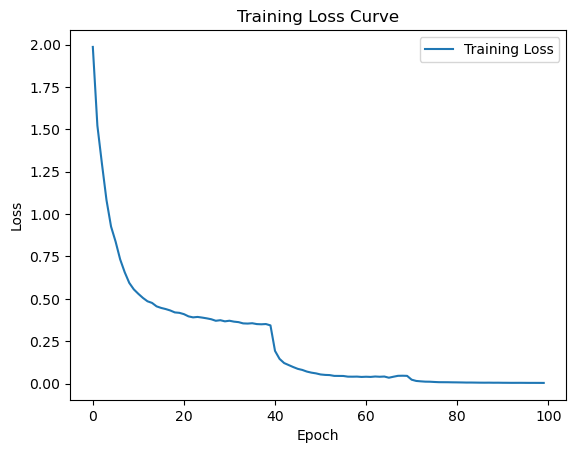

In [3]:
criterion = nn.CrossEntropyLoss()  # 构建损失函数为交叉熵损失

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)  # 初始学习率 动量 权重衰减
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70], gamma=0.1)  #学习率衰减 在第40，70轮衰减为10%

# 训练过程
train_losses = []  # 记录训练损失
epochs = 100  # 100次训练过程

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 记录每个epoch的平均损失
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')
    scheduler.step()

# 绘制训练损失曲线
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig('loss_curve.png')
plt.show()

# **数据后处理**

In [4]:
model.eval()
all_labels = []
all_preds = []

# 模型性能评估
with torch.no_grad():
    correct = 0
    total = 0
    # 测试集计算
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 收集预测结果和真实标签
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# 计算整体准确率
accuracy = 100 * correct / total
print(f'Overall Accuracy: {accuracy:.2f}%')

# 计算每个类别的精确率
class_precision = precision_score(all_labels, all_preds, average=None)
for i, prec in enumerate(class_precision):
    print(f'Precision for class {classes[i]:5s}: {prec*100:.2f}%')

Overall Accuracy: 94.27%
Precision for class plane: 94.51%
Precision for class car  : 97.02%
Precision for class bird : 93.71%
Precision for class cat  : 88.05%
Precision for class deer : 93.18%
Precision for class dog  : 90.74%
Precision for class frog : 94.97%
Precision for class horse: 97.65%
Precision for class ship : 96.58%
Precision for class truck: 96.39%
